<a href="https://colab.research.google.com/github/haihttran/statistics/blob/master/Wood2_Challenge1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from scipy import stats
from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**QUESTION 1 & 2:**

In [ ]:
%%bigquery --project haith-2913 df1

WITH
/*Retrieve all user id of the cohort that first launched game on Feb 10th*/
first_launch_cohort AS (
  SELECT DISTINCT user_pseudo_id AS new_user_id,
    TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY) AS date
    FROM `wood-2.analytics_155124895.events_*`
    WHERE 
      event_name = 'first_open'
      AND _TABLE_SUFFIX BETWEEN '202002009' AND '20200211'
      AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY)) = '20200210'
),
/*Retrieve all user id of the cohort that retained the game the period of next 6 days*/
retained_user_cohort AS (
  SELECT DISTINCT user_pseudo_id AS retained_user_id,
  TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY) AS date
    FROM `wood-2.analytics_155124895.events_*`
    WHERE 
      event_name = 'user_engagement'
      AND _TABLE_SUFFIX BETWEEN '20200210' AND '20200216'
      AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY))
      BETWEEN '20200211' AND '20200216'
)
/*Look for the users that first open game on Feb 2nd and retained it in next days*/
SELECT 
  TIMESTAMP_DIFF(R.date, F.date, DAY) AS day_n,
  COUNT(*) AS number
  FROM first_launch_cohort AS F
    INNER JOIN retained_user_cohort AS R
    ON F.new_user_id = R.retained_user_id
    AND F.date < R.date
  GROUP BY 1
  ORDER BY 1


In [ ]:
df1

,day_n,number
0,1,70
1,2,66
2,3,55
3,4,47
4,5,42
5,6,37


*   Day 5 Retention of users who launched Wood2 for the first time on February 1 is 42.
*   There are 55 users who first launched Wood2 on February 10 returned on Day 3






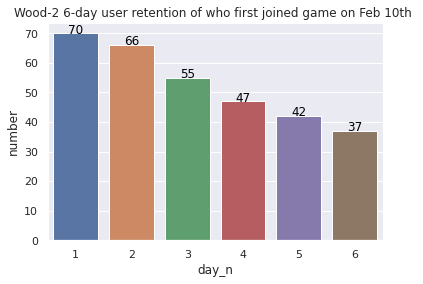

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="day_n", y="number", data=df1)
for index, row in df1.iterrows():
    ax.text(row.name,row.number, round(row.number,2), color='black', ha="center")
plt.title('Wood-2 6-day user retention of who first joined game on Feb 10th ')
plt.show()

**QUESTION 3:**

In [ ]:
%%bigquery --project haith-2913 df2
/*Count number of users who joined Wood-2 in March*/
SELECT COUNT (DISTINCT user_pseudo_id) as first_joined_in_March
    FROM `wood-2.analytics_155124895.events_*`
    WHERE 
      event_name = 'first_open'
      AND _TABLE_SUFFIX BETWEEN '20200229' AND '20200401'
      AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY)) 
      BETWEEN '20200301' AND '20200331'

In [ ]:
df2

,first_joined_in_March
0,7108


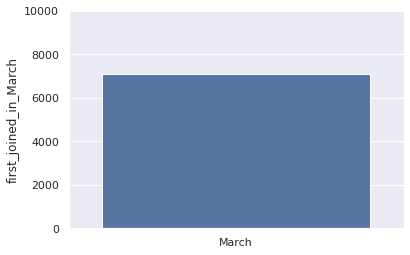

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(x=["March"], y="first_joined_in_March", data=df2)
ax.set(ylim=(0, 10000))
plt.show()

**QUESTION 4:**

In [ ]:
%%bigquery --project haith-2913 df3
WITH
/*Retrieve all user id of the cohort that first launched game  Feb*/
first_launch_cohort AS (
  SELECT DISTINCT user_pseudo_id AS new_user_id,
    TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY) AS date
    FROM `wood-2.analytics_155124895.events_*`
    WHERE 
      event_name = 'first_open'
      AND _TABLE_SUFFIX BETWEEN '20200131' AND '20200301'
      AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY))
      BETWEEN '20200201' AND '20200229'
),
/*Retrieve all user id of the cohort that retained the game  March*/
retained_user_cohort AS (
  SELECT DISTINCT user_pseudo_id AS retained_user_id,
  TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY) AS date
    FROM `wood-2.analytics_155124895.events_*`
    WHERE 
      event_name = 'user_engagement'
      AND _TABLE_SUFFIX BETWEEN '20200229' AND '20200401'
      AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY))
      BETWEEN '20200301' AND '20200331'
)
/*Look for the users that first open game in Feb and retained it in March*/
SELECT 
  COUNT(*) AS number
  FROM first_launch_cohort AS F
    INNER JOIN retained_user_cohort AS R
    ON F.new_user_id = R.retained_user_id
    AND F.date < R.date

In [ ]:
df3

,number
0,27848


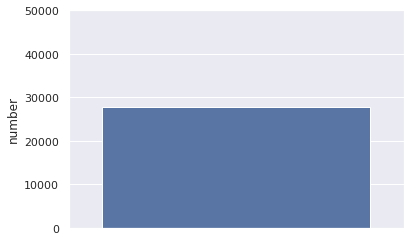

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(y="number", data=df3)
ax.set(ylim=(0, 50000))
plt.show()

**QUESTION 5:**

The number of Monthly Active Users (MAU) is a variable that varies from month to month. Therefore, with the same measurement, we can treat the series of MAU as a time series. To predict the value of MAU of the incoming October, we will apply a traditional, simple but yet quite powerful technique: univariate forecasting of time series.

Firstly, we need to obtain the raw dataset from Wood-2 Firebase BigQuery:

In [ ]:
%%bigquery --project haith-2913 df4
/*Get numbers of active users, grouped by month*/
SELECT
  FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), MONTH)) AS month,
  COUNT (DISTINCT user_pseudo_id) AS active_user_count
  FROM
    `wood-2.analytics_155124895.events_*`,
    UNNEST(event_params) AS params
    WHERE
    _TABLE_SUFFIX BETWEEN '20180101' AND '20200930'
    AND event_name IN ('user_engagement','first_open')
    AND params.key = 'engagement_time_msec'
  GROUP BY month
  ORDER BY month

An overview to first few rows of the result:

In [ ]:
df4.head()


,month,active_user_count
0,20180601,96219
1,20180701,178313
2,20180801,175363
3,20180901,161622
4,20181001,157430


Secondly, we might need to take a look at the visualization of the time series since it would provide some initial insight of the data:

In [ ]:
#Lambda function for calculating rolling value
rll = lambda df : df.active_user_count.rolling(window=5, min_periods=1)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

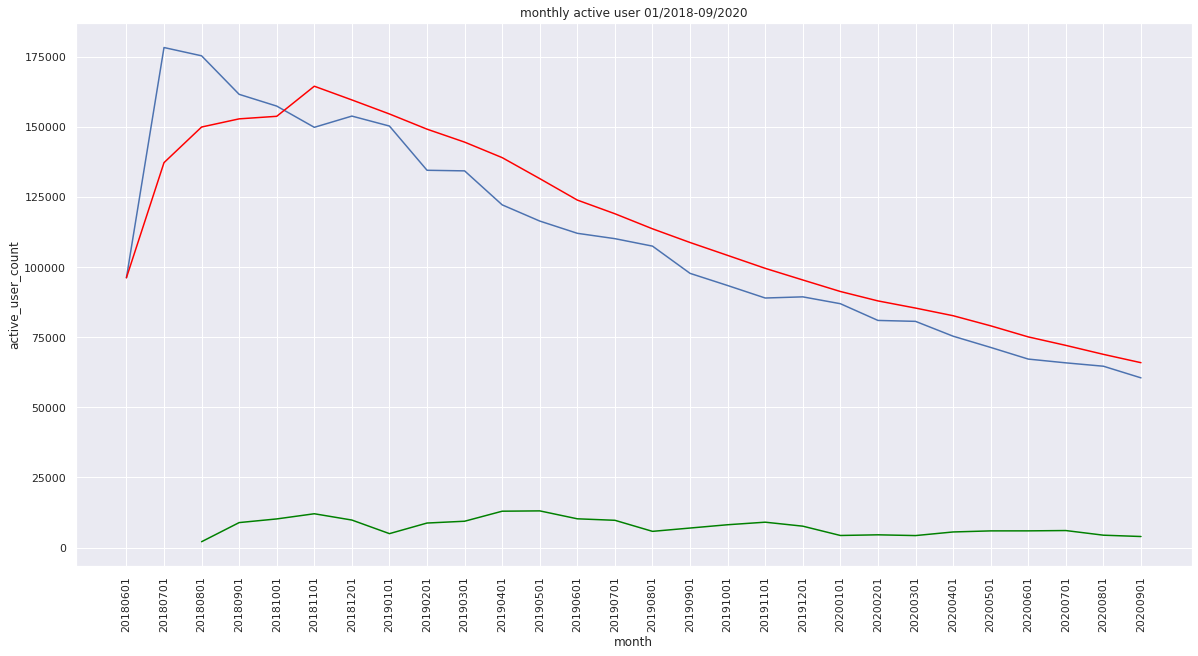

In [ ]:
#Plotting the time series, rolling mean and moving std
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20, 10))
sns.lineplot(y="active_user_count", x="month", data=df4)
sns.lineplot(y=rll(df4).mean(), x="month", color="red", data=df4)
sns.lineplot(y=rll(df4.iloc[1:]).std(), x="month", color="green", data=df4)
plt.xticks(rotation=90)
plt.title('monthly active user 01/2018-09/2020')
plt.show()

Prepare the dataset for training and testing the forecasting model.
 is accomplished by duplicating the original data set and rename the columns to "ds" and "y" since Facebook Prophet library requires the naming convention in which "ds" is the timestamp field and "y" is the value of observation.

In [ ]:
temp = df4.copy()
temp.rename(columns= {'month':'ds','active_user_count':'y'}, inplace = True)
temp['ds']= pd.to_datetime(temp['ds'])
temp.head()

,ds,y
0,2018-06-01,96219
1,2018-07-01,178313
2,2018-08-01,175363
3,2018-09-01,161622
4,2018-10-01,157430


Finally, we create the model with Prophet, fit the prepared data and then forecast the values of MAU in next 3 months (October, November, December) with lower and upper bounds:

In [ ]:
# define the model
model = Prophet()
# fit the model
model.fit(temp)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


In [ ]:
# define the period for which we want a prediction
future = list()
for i in range(10, 13):
	date = '2020-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
forecast = model.predict(future)

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds          yhat    yhat_lower    yhat_upper
0 2020-10-01  48777.941313  33011.603422  64308.737486
1 2020-11-01  39286.903494  24511.793506  53672.027247
2 2020-12-01  56965.666183  42818.328563  71865.313036


Visualize the forecasted values of the next 3 months.

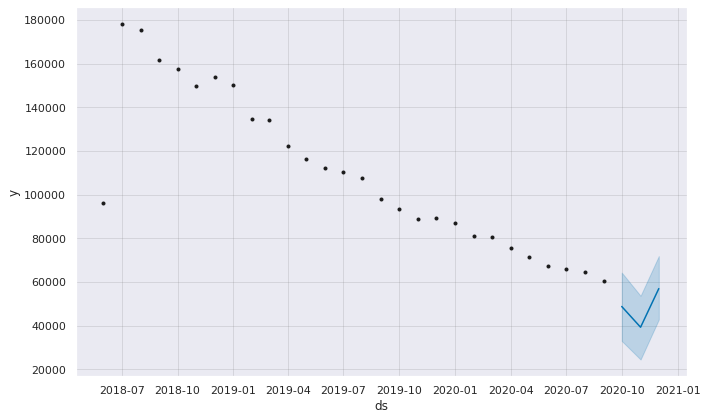

In [ ]:
model.plot(forecast);